# Akantu Tutorial: Defining your own constitutive law

In [1]:
import numpy as np
import akantu as aka
import plate_hole # import routines from the plate_hole tutorial

## Using different constitutive laws

In [2]:
material_file = """
debug_level = 10
material plastic_linear_isotropic_hardening [
    name = steel
    rho = 7800     # density
    E   = 2.1e11   # young's modulus
    nu  = 0.3      # poisson's ratio
    sigma_y = 250e6
]"""

# writing the material file
open('material.dat', 'w').write(material_file)

#reading the material file
material_file = 'material.dat'
aka.parseInput(material_file)

Info    : Running 'gmsh -2 -order 1 -o plate.msh plate.geo' [Gmsh 4.8.4, 1 node, max. 1 thread]
Info    : Started on Tue May 23 11:43:09 2023
Info    : Reading 'plate.geo'...
Info    : Done reading 'plate.geo'
Info    : Meshing 1D...
Info    : [  0%] Meshing curve 1 (Circle)
Info    : [ 20%] Meshing curve 2 (Line)
Info    : [ 40%] Meshing curve 3 (Line)
Info    : [ 60%] Meshing curve 4 (Line)
Info    : [ 80%] Meshing curve 5 (Line)
Info    : Done meshing 1D (Wall 0.00813813s, CPU 0.008121s)
Info    : Meshing 2D...
Info    : Meshing surface 7 (Plane, Frontal-Delaunay)
Info    : Done meshing 2D (Wall 0.0744661s, CPU 0.070626s)
Info    : 2058 nodes 4118 elements
Info    : Writing 'plate.msh'...
Info    : Done writing 'plate.msh'
Info    : Stopped on Tue May 23 11:43:09 2023 (From start: Wall 0.0891027s, CPU 0.179592s)
Mesh generated


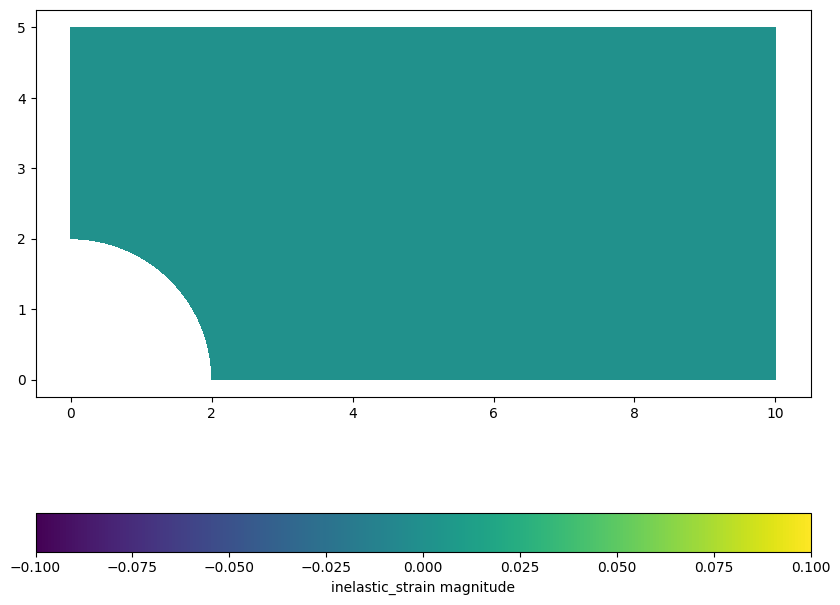

In [3]:
plate_hole.solve_plate_hole(material_file, 'inelastic_strain', 5e6)

## Defining a local constitutive law in Akantu

A local constitutive behavior in *Akantu* necessitates to provide a few routines, mainly to compute
*stress* and *tangent moduli*. In this tutorial we will show how to implement an elastic, plane strain, constitutive behavior to start with:

$$\sigma_{ij} = \lambda \epsilon_{kk} \delta_{ij} + 2 \mu \epsilon_{ij}$$

which can be programmed as follows for a set of quadrature points:

In [4]:
def computeStress(sigma_on_quads):
    n_quads = epsilon_on_quads.shape[0]
    sigma = sigma_on_quads.reshape((n_quads, 2, 2))
    trace = np.einsum('aii->a', epsilon_on_quads)

    sigma[:, :, :] = (np.einsum('a,ij->aij', trace,
                              lame_lambda * np.eye(2))
                    + 2. * lame_mu * epsilon_on_quads)
    return sigma

This same relation can be written in voigt notation, also highlighting the elastic tensor:

$$\begin{align}
  \left[\begin{array}{c}
      \sigma_{11}\\
      \sigma_{22}\\
      \sigma_{12}\\
    \end{array}\right]
  &= \left[
    \begin{array}{ccc}
      \lambda+2\mu & \lambda   & 0\\
      \lambda   & \lambda+2\mu & 0\\
      0   & 0   & \mu\\
    \end{array}\right]
  \left[\begin{array}{c}
      \varepsilon_{11}\\
      \varepsilon_{22}\\
      2\varepsilon_{12}\\
    \end{array}\right]
\end{align}$$

For making a static solve, the tangent stiffness will be extracted from the elastic tensor which can be programmed as:

In [5]:
def computeTangentModuli(tangents_on_quads):
    n_quads = tangent_matrix.shape[0]
    tangent = tangent_matrix.reshape(n_quads, 3, 3)

    Miiii = lame_lambda + 2 * lame_mu
    Miijj = lame_lambda
    Mijij = lame_mu

    tangent_on_quads[:, 0, 0] = Miiii
    tangent_on_quads[:, 1, 1] = Miiii
    tangent_on_quads[:, 0, 1] = Miijj
    tangent_on_quads[:, 1, 0] = Miijj
    tangent_on_quads[:, 2, 2] = Mijij

In the end, these routines must be inserted in a class that Akantu will receive as a material declaration. Several important routines are required:

- computeStress: should return the stresses per quadrature point
- computeTangentModuli: should return the tangent moduli per quadrature point
- init: the  constructor declaring the accepted parameters and initialize the material
- initMaterial: perform some initialization (here computes the lame constants from the Youngs and Poisson parameters)

For the elastic isotropic law this would be the following *class* declaration

In [6]:
class LocalElastic(aka.Material):

    def __init__(self, model, _id):
        super().__init__(model, _id)
        super().registerParamReal('E',
                                  aka._pat_readable | aka._pat_parsable,
                                  'Youngs modulus')
        super().registerParamReal('nu',
                                  aka._pat_readable | aka._pat_parsable,
                                  'Poisson ratio')

    def initMaterial(self):
        nu = self.getReal('nu')
        E = self.getReal('E')
        self.mu = E / (2 * (1 + nu))
        self.lame_lambda = nu * E / (
            (1. + nu) * (1. - 2. * nu))
        
        # Second Lame coefficient (shear modulus)
        self.lame_mu = E / (2. * (1. + nu))
        super().initMaterial()

    # constitutive law
    def computeStress(self, el_type, ghost_type):
        grad_u = self.getGradU(el_type, ghost_type)
        sigma = self.getStress(el_type, ghost_type)

        n_quads = grad_u.shape[0]
        grad_u = grad_u.reshape((n_quads, 2, 2))
        sigma = sigma.reshape((n_quads, 2, 2))
        
        epsilon = 0.5 * (grad_u + np.einsum('aij->aji', grad_u))
        epsilon = epsilon
        
        trace = np.einsum('aii->a', grad_u)

        sigma[:, :, :] = (
            np.einsum('a,ij->aij', trace,
                      self.lame_lambda * np.eye(2))
            + 2. * self.lame_mu * epsilon)

    # constitutive law tangent modulii
    def computeTangentModuli(self, el_type, tangent_matrix, ghost_type):
        n_quads = tangent_matrix.shape[0]
        tangent = tangent_matrix.reshape(n_quads, 3, 3)

        Miiii = self.lame_lambda + 2 * self.lame_mu
        Miijj = self.lame_lambda
        Mijij = self.lame_mu

        tangent[:, 0, 0] = Miiii
        tangent[:, 1, 1] = Miiii
        tangent[:, 0, 1] = Miijj
        tangent[:, 1, 0] = Miijj
        tangent[:, 2, 2] = Mijij

The final stage is to declare the material to *Akantu* which is done by associating a keyword (used in the material.dat file) to the creation of a new material:

In [7]:
# register material to the MaterialFactory
def allocator(_dim, unused, model, _id):
    return LocalElastic(model, _id)

mat_factory = aka.MaterialFactory.getInstance()
mat_factory.registerAllocator("local_elastic", allocator)

## Create the material.dat file with our custom constitutive law

In [8]:
material_file = """
material local_elastic [
    name = fictive
    rho = 1     # density
    E   = 1   # young's modulus
    nu  = 0.3      # poisson's ratio
]"""

# writing the material file
open('material.dat', 'w').write(material_file)

#reading the material file
material_file = 'material.dat'
aka.parseInput(material_file)

## Solve again the problem with plate and hole (see the plat_hole tutorial for details)

Info    : Running 'gmsh -2 -order 1 -o plate.msh plate.geo' [Gmsh 4.8.4, 1 node, max. 1 thread]
Info    : Started on Tue May 23 11:43:12 2023
Info    : Reading 'plate.geo'...
Info    : Done reading 'plate.geo'
Info    : Meshing 1D...
Info    : [  0%] Meshing curve 1 (Circle)
Info    : [ 20%] Meshing curve 2 (Line)
Info    : [ 40%] Meshing curve 3 (Line)
Info    : [ 60%] Meshing curve 4 (Line)
Info    : [ 80%] Meshing curve 5 (Line)
Info    : Done meshing 1D (Wall 0.0083108s, CPU 0.008258s)
Info    : Meshing 2D...
Info    : Meshing surface 7 (Plane, Frontal-Delaunay)
Info    : Done meshing 2D (Wall 0.0779951s, CPU 0.077982s)
Info    : 2058 nodes 4118 elements
Info    : Writing 'plate.msh'...
Info    : Done writing 'plate.msh'
Info    : Stopped on Tue May 23 11:43:12 2023 (From start: Wall 0.0930164s, CPU 0.193705s)
Mesh generated


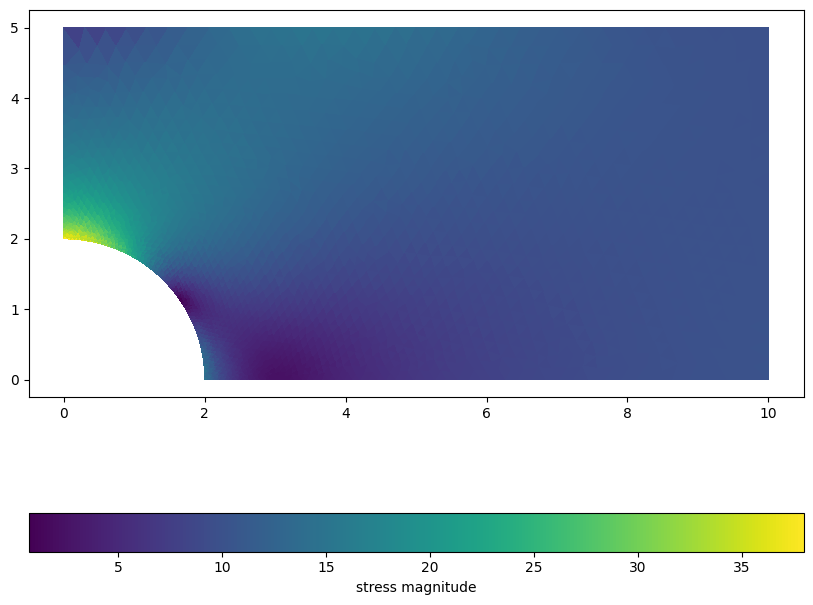

In [9]:
plate_hole.solve_plate_hole(material_file)

## Defining internal fields for your constitutive laws

It is really comon to need internal fields to conceive constitutive laws (e.g. plastic strain, damage, etc...)

The second part of this tutorial is about declaring and using a scalar field to scale the Youngs modulus with a criterion based on the position. This example should be enough to conceive any other local constitutive law. For demonstration, the position of quadrature points will also be computed.

Please note:

- the declaration of the internal fields in the "init constructor"
- the construction of the quadrature points position
- the setup of the **factor** field values based on the quadrature points (loop over all quadrature points)


In [10]:
class ScaledElastic(LocalElastic):

    def __init__(self, model, _id):
        super().__init__(model, _id)
        
        # change it to have the initialize wrapped
        self.registerInternalReal('factor', 1)
        self.registerInternalReal('quad_coordinates', 2)
        
    def initMaterial(self):
        super().initMaterial()
        
        # get the internals as numpy arrays
        quad_coords = self.getInternalReal("quad_coordinates")
        factor = self.getInternalReal("factor")

        # computes the quadrature point positions (by interpolation)
        model = self.getModel()
        model.getFEEngine().computeIntegrationPointsCoordinates(quad_coords, self.getElementFilter())

        # set the upper (resp. lower) elements to a factor 1. (resp. 0.5)
        for elem_type in factor.elementTypes():
            _factor = factor(elem_type)
            coords = quad_coords(elem_type)

            _factor[:] = 1.
            _factor[coords[:, 1] < 2.5] = .5


    # constitutive law
    def computeStress(self, el_type, ghost_type):
        super().computeStress(el_type, ghost_type)
        sigma = self.getStress(el_type, ghost_type)
        
        # scales the stress with the factor
        factor = self.getInternalReal("factor")(el_type)
        sigma[:, :] = np.einsum('ai, a->ai', sigma, factor.ravel())


    # constitutive law tangent modulii
    def computeTangentModuli(self, el_type, tangent_matrix, ghost_type):
        super().computeTangentModuli(el_type, tangent_matrix, ghost_type)
        
        # scales the tangent with a factor
        factor = self.getInternalReal("factor")(el_type)
        tangent_matrix[:, :] = np.einsum('ai, a->ai', tangent_matrix, factor.ravel())

In [11]:
# register material to the MaterialFactory
def allocator(_dim, unused, model, _id):
    return ScaledElastic(model, _id)

mat_factory = aka.MaterialFactory.getInstance()
mat_factory.registerAllocator("scaled_elastic", allocator)

# creates the material
material_file = """
material scaled_elastic [
    name = fictive
    rho = 1     # density
    E   = 1   # young's modulus
    nu  = 0.3      # poisson's ratio
]"""

# writing the material file
open('material.dat', 'w').write(material_file)

#reading the material file
material_file = 'material.dat'
aka.parseInput(material_file)

Info    : Running 'gmsh -2 -order 1 -o plate.msh plate.geo' [Gmsh 4.8.4, 1 node, max. 1 thread]
Info    : Started on Tue May 23 11:43:14 2023
Info    : Reading 'plate.geo'...
Info    : Done reading 'plate.geo'
Info    : Meshing 1D...
Info    : [  0%] Meshing curve 1 (Circle)
Info    : [ 20%] Meshing curve 2 (Line)
Info    : [ 40%] Meshing curve 3 (Line)
Info    : [ 60%] Meshing curve 4 (Line)
Info    : [ 80%] Meshing curve 5 (Line)
Info    : Done meshing 1D (Wall 0.00865251s, CPU 0.008584s)
Info    : Meshing 2D...
Info    : Meshing surface 7 (Plane, Frontal-Delaunay)
Info    : Done meshing 2D (Wall 0.0765531s, CPU 0.072554s)
Info    : 2058 nodes 4118 elements
Info    : Writing 'plate.msh'...
Info    : Done writing 'plate.msh'
Info    : Stopped on Tue May 23 11:43:14 2023 (From start: Wall 0.0922222s, CPU 0.183925s)
Mesh generated


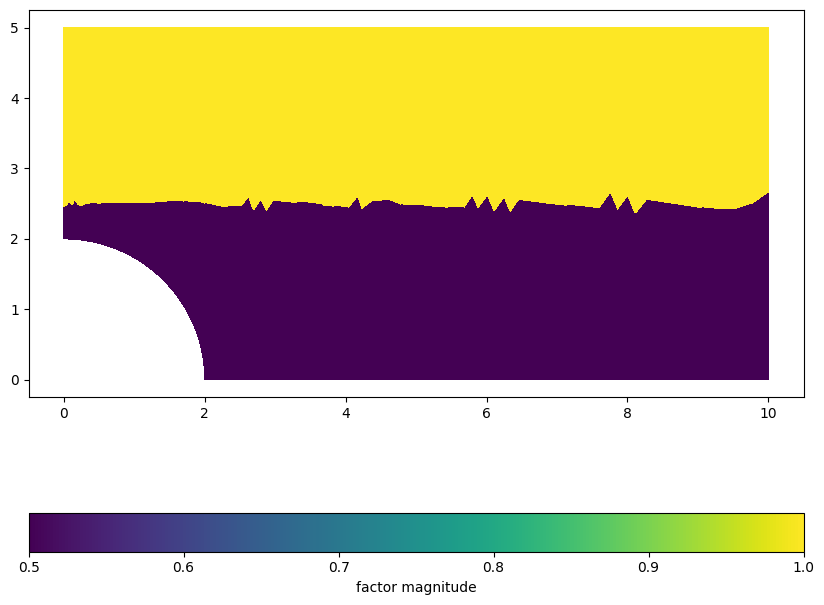

In [12]:
plate_hole.solve_plate_hole(material_file, 'factor')

## Simple damage material (Marigo)

This damage evolution law is energy based as defined by Marigo. It is an isotropic damage law.

$$\begin{aligned}
     Y &= \frac{1}{2}\boldsymbol{\varepsilon}:\boldsymbol{C}:\boldsymbol{\varepsilon}\\
     F &= Y - Y_d - S d\\
     d &= \left\{
       \begin{array}{l l}
         \mathrm{min}\left(\frac{Y-Y_d}{S},\;1\right) & \mathrm{if}\; F > 0\\
         \mathrm{unchanged} & \mathrm{otherwise}
       \end{array}
     \right.\end{aligned}$$

In this formulation, $Y$ is the strain energy release rate,
$Y_d$ the rupture criterion and $S$ the damage energy. The
non-local version of this damage evolution law is constructed by
averaging the energy $Y$.

In [13]:
class LocalDamage(LocalElastic):

    def __init__(self, model, _id):
        super().__init__(model, _id)
        self.registerParamReal('Yd',
                               aka._pat_readable | aka._pat_parsable,
                               'Rupture criterion')
        self.registerParamReal('Sd',
                               aka._pat_readable | aka._pat_parsable,
                               'Damage energy')
        self.registerInternalReal('damage', 1)

    def initMaterial(self):
        self.Yd = self.getReal('Yd')
        self.Sd = self.getReal('Sd')
        super().initMaterial()

    # constitutive law
    def computeStress(self, el_type, ghost_type):
        super().computeStress(el_type, ghost_type)
        grad_u = self.getGradU(el_type, ghost_type)
        sigma = self.getStress(el_type, ghost_type)

        n_quads = grad_u.shape[0]
        grad_u = grad_u.reshape((n_quads, 2, 2))
        sigma = sigma.reshape((n_quads, 2, 2))
        
        epsilon = 0.5 * (grad_u + np.einsum('aij->aji', grad_u))
        epsilon = epsilon
        
        dam = self.getInternalReal("damage")(el_type).reshape(n_quads)
        
        Y = np.einsum('aij,aij->a', epsilon, sigma) / 2.
        Fd = Y - self.Yd - self.Sd * dam
       
        ids = np.where(Fd > 0)
        dam[ids] = (Y[ids] - self.Yd)/self.Sd
        
        dam[:] = np.minimum(dam, .9)
        
        sigma[:, :, :] = np.einsum('aij, a->aij', sigma, (1.-dam))

    # constitutive law tangent modulii
    def computeTangentModuli(self, el_type, tangent_matrix, ghost_type):
        super().computeTangentModuli(el_type, tangent_matrix, ghost_type)
        n_quads = tangent_matrix.shape[0]
        tangent = tangent_matrix.reshape(n_quads, 3, 3)
        
        dam = self.getInternalReal("damage")(el_type).reshape(n_quads)
        tangent[:, :, :] = np.einsum('aij, a->aij', tangent, (1. - dam))

In [14]:
# register material to the MaterialFactory
def allocator(_dim, unused, model, _id):
    return LocalDamage(model, _id)

mat_factory = aka.MaterialFactory.getInstance()
mat_factory.registerAllocator("local_damage", allocator)

In [15]:
# creates the material
material_file = """
material local_damage [
    name = fictive
    rho  = 1    # density
    E    = 1    # young's modulus
    nu   = 0.3  # poisson's ratio
    Yd   = 200
    Sd   = 1000
]"""

# writing the material file
open('material.dat', 'w').write(material_file)

#reading the material file
material_file = 'material.dat'
aka.parseInput(material_file)

/tmp/ipykernel_262618/1386721455.py:1: DeprecationWarning: setDebugLevel() is deprecated, it has moved in the submodule debug
  aka.setDebugLevel(aka.dblInfo)


Info    : Running 'gmsh -2 -order 1 -o plate.msh plate.geo' [Gmsh 4.8.4, 1 node, max. 1 thread]
Info    : Started on Tue May 23 11:43:16 2023
Info    : Reading 'plate.geo'...
Info    : Done reading 'plate.geo'
Info    : Meshing 1D...
Info    : [  0%] Meshing curve 1 (Circle)
Info    : [ 20%] Meshing curve 2 (Line)
Info    : [ 40%] Meshing curve 3 (Line)
Info    : [ 60%] Meshing curve 4 (Line)
Info    : [ 80%] Meshing curve 5 (Line)
Info    : Done meshing 1D (Wall 0.0069199s, CPU 0.006921s)
Info    : Meshing 2D...
Info    : Meshing surface 7 (Plane, Frontal-Delaunay)
Info    : Done meshing 2D (Wall 0.0591741s, CPU 0.058509s)
Info    : 2058 nodes 4118 elements
Info    : Writing 'plate.msh'...
Info    : Done writing 'plate.msh'
Info    : Stopped on Tue May 23 11:43:16 2023 (From start: Wall 0.071733s, CPU 0.124407s)
Mesh generated


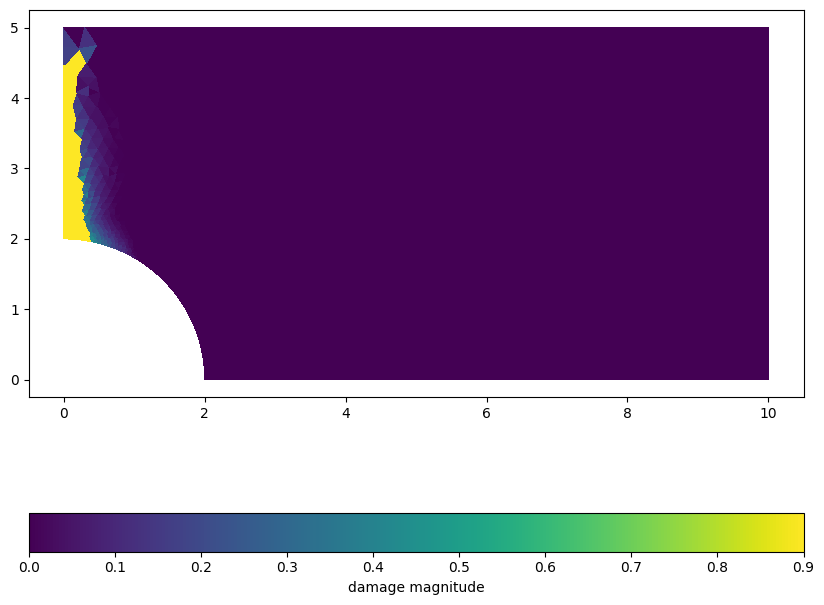

In [16]:
aka.setDebugLevel(aka.dblInfo)
plate_hole.solve_plate_hole(material_file, 'damage')